In [1]:
import numpy as np
from catboost import CatBoostClassifier, datasets
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# AMAZON

In [2]:
positive_steps = [2000, 5000, 10000, 20000, 30872]
negative_steps = [500, 1000, 1897]

# Catboost

In [3]:
catboost_scores = np.zeros(shape=(len(negative_steps), len(positive_steps)))
catboost_means = np.zeros(shape=(len(negative_steps), len(positive_steps)))
for i, positive in enumerate(tqdm(positive_steps)):
    for j, negative in enumerate(tqdm(negative_steps, leave=False)):
        train_df, _ = datasets.amazon() # nice datasets with categorical features only :D
        train_df = (
            pd
            .concat([train_df[train_df.ACTION == 1][:positive], train_df[train_df.ACTION == 0][:negative]])
            .sample(frac=1)
            .reset_index(drop=True)
        )
        y = train_df['ACTION']
        X = train_df.drop(columns='ACTION') # or X = train_df.drop('ACTION', axis=1)
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)
        
        condition = True # here we specify what condition should be satisfied only by the names of categorical features
        cat_features_names = [col for col in X.columns if condition]
        cat_features = [X.columns.get_loc(col) for col in cat_features_names]

        params = {'loss_function':'Logloss',
                  'eval_metric':'AUC',
                  'cat_features': cat_features,
                  'early_stopping_rounds': 200,
                  'verbose': False,  # 200, # output to stdout info about training process every 200 iterations
                 }
        cbc_1 = CatBoostClassifier(**params)
        cbc_1.fit(
            X_train, y_train,
            eval_set=(X_valid, y_valid),
            use_best_model=True,
            plot=False,
        )
        catboost_scores[j, i] = accuracy_score(y_valid, cbc_1.predict(X_valid))
        catboost_means[j, i] = cbc_1.predict(X_valid).mean()

## Keras

In [9]:
keras_scores = np.zeros(shape=(len(negative_steps), len(positive_steps)))
keras_means = np.zeros(shape=(len(negative_steps), len(positive_steps)))
for i, positive in enumerate(tqdm(positive_steps)):
    for j, negative in enumerate(tqdm(negative_steps, leave=False)):
        train_df, _ = datasets.amazon() # nice datasets with categorical features only :D
        train_df = (
            pd
            .concat([train_df[train_df.ACTION == 1][:positive], train_df[train_df.ACTION == 0][:negative]])
            .sample(frac=1)
            .reset_index(drop=True)
        )
        y = train_df['ACTION']
        X = train_df.drop(columns='ACTION') # or X = train_df.drop('ACTION', axis=1)

        for col in X.columns:
            X[col] = X[col].astype('category').cat.codes.astype('float32')
            if X[col].max() == X[col].min():
                col_range = 1
            else:
                col_range = X[col].max() - X[col].min()
            X[col] = (X[col] - X[col].min()) / col_range

        X = X.astype('float32')
        y = y.astype('float32')
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)
        
        model = keras.Sequential([
            keras.layers.Dense(64, activation='relu'),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(64, activation='relu'),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(16, activation='relu'),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(1, activation='sigmoid'),
        ])
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss",
                min_delta=0,
                patience=0,
                verbose=0,
                mode="auto",
                baseline=None,
                restore_best_weights=False,
            )
        ]
        model.fit(
            X_train, y_train,
            epochs=15, validation_data=(X_valid, y_valid),
            callbacks=callbacks, verbose=False,
        )

        test_loss, test_acc = model.evaluate(X_valid,  y_valid, verbose=0)
        
        keras_scores[j, i] = test_acc
        keras_means[j, i] = model.predict_classes(X_valid).mean()

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


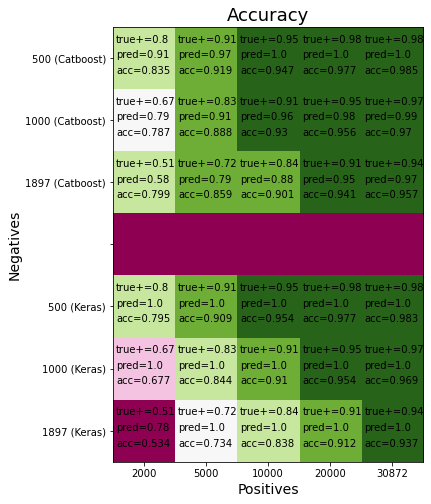

In [10]:
cmap = np.concatenate([
    catboost_scores,
    np.full((1, len(positive_steps)), min(catboost_scores.min(), keras_scores.min())),
    keras_scores
])
plt.figure(figsize=(10, 8))
plt.title(f'Accuracy', fontsize=18)
plt.imshow(cmap, cmap=plt.get_cmap("PiYG", 7))
plt.xlabel('Positives', fontsize=14)
plt.ylabel('Negatives', fontsize=14)
plt.xticks(range(len(positive_steps)), positive_steps)
plt.yticks(
    range(len(negative_steps)*2+1),
    [f'{x} (Catboost)' for x in negative_steps] + [''] + [f'{x} (Keras)' for x in negative_steps]
)
for i in range(len(negative_steps)):
    for j in range(len(positive_steps)):
        plt.text(j-0.45, i-0.25, f'true+={round(positive_steps[j] / (positive_steps[j] + negative_steps[i]), 2)}')
        plt.text(j-0.45, i, f'pred={round(catboost_means[i, j], 2)}')
        plt.text(j-0.45, i+0.25, f'acc={round(catboost_scores[i, j], 3)}')
        plt.text(j-0.45, i-0.25 + len(negative_steps) + 1, f'true+={round(positive_steps[j] / (positive_steps[j] + negative_steps[i]), 2)}')
        plt.text(j-0.45, i + len(negative_steps) + 1, f'pred={round(keras_means[i, j], 2)}')
        plt.text(j-0.45, i+0.25 + len(negative_steps) + 1, f'acc={round(keras_scores[i, j], 3)}')

# Plot Keras training

In [6]:
train_df, _ = datasets.amazon() # nice datasets with categorical features only :D
train_df = train_df.sample(frac=1).reset_index(drop=True)
y = train_df['ACTION']
X = train_df.drop(columns='ACTION') # or X = train_df.drop('ACTION', axis=1)

for col in X.columns:
    X[col] = X[col].astype('category').cat.codes.astype('float32')
    if X[col].max() == X[col].min():
        col_range = 1
    else:
        col_range = X[col].max() - X[col].min()
    X[col] = (X[col] - X[col].min()) / col_range

X = X.astype('float32')
y = y.astype('float32')
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)

scores = {}

In [7]:
for dropout_value in tqdm([0.25, 0.4, 0.5]):
    for layer1 in tqdm([32, 64, 128], leave=False):
        for layer2 in [32, 64, 128]:
            for layer3 in [0, 16]:
                layers = [
                    keras.layers.Dense(layer1, activation='relu'),
                    keras.layers.Dropout(dropout_value),
                    keras.layers.Dense(layer2, activation='relu'),
                    keras.layers.Dropout(dropout_value),
                ]
                if layer3:
                    layers += [
                        keras.layers.Dense(layer3, activation='relu'),
                        keras.layers.Dropout(dropout_value),
                    ]
                layers += [
                    keras.layers.Dense(1, activation='sigmoid'),
                ]
                model = keras.Sequential(layers)
                model.compile(optimizer='adam',
                              loss='binary_crossentropy',
                              metrics=['accuracy'])
                callbacks = [
                    tf.keras.callbacks.EarlyStopping(
                        monitor="val_loss",
                        min_delta=0,
                        patience=0,
                        verbose=0,
                        mode="auto",
                        baseline=None,
                        restore_best_weights=False,
                    )
                ]
                history = model.fit(
                    X_train, y_train,
                    epochs=12, validation_data=(X_valid, y_valid),
                    callbacks=callbacks, verbose=False,
                )

                test_loss, test_acc = model.evaluate(X_valid,  y_valid, verbose=0)
                key = 'l1_{}_l2_{}_l3_{}_dr_{}'.format(layer1, layer2, layer3, dropout_value)
                scores[key] = history.history['val_accuracy']

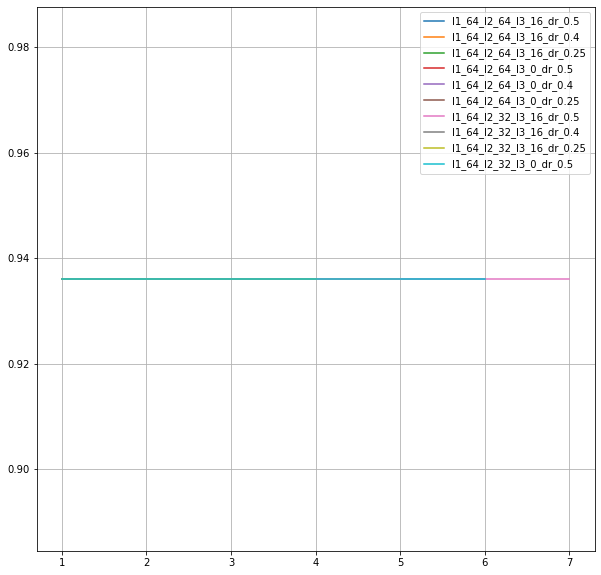

In [8]:
by_max = {(max(values), key): key for (key, values) in scores.items()}
best_key = [by_max[x] for x in sorted(by_max, reverse=True)[:10]]
plt.figure(figsize=(10, 10))
plt.grid(True)
for key in best_key:
    plt.plot(range(1, len(scores[key])+1), scores[key], label=key)
plt.legend()
plt.show()